In [ ]:
# Project Part 2 - Rectification

# benchmarks:
#  30.0 PSNR
#  0.90 SSIM

In [1]:
!pip install largestinteriorrectangle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import largestinteriorrectangle as lir
import cv2
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
from natsort import natsorted
from glob import glob
from tqdm.notebook import tqdm
import random

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

In [4]:
input_files = natsorted(glob('/content/gdrive/MyDrive/Colab Notebooks/188/stage2_rectification/input_imgs/*.png'))
warped_files = natsorted(glob('/content/gdrive/MyDrive/Colab Notebooks/188/stage2_rectification/warped_imgs/*.png'))

In [5]:
def psnr_ssim_rect(orig_img, rectified_img):
    # Convert the image to grayscale
    gray = cv2.cvtColor(rectified_img, cv2.COLOR_BGR2GRAY)
    # Threshold the image to create a binary image (black and white)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    grid = thresh.astype(bool)

    rectangle = lir.lir(grid)

    (x_min, y_min) = lir.pt1(rectangle)
    (x_max, y_max) = lir.pt2(rectangle)

    # Crop the image using the inscribed rectangle's coordinates
    cropped_img = orig_img[y_min:y_max, x_min:x_max]
    cropped_img_rect = rectified_img[y_min:y_max, x_min:x_max]

    psnr_out = psnr(cropped_img, cropped_img_rect)
    ssim_out = ssim(cropped_img, cropped_img_rect, multichannel=True)

    return (psnr_out, ssim_out)

def display_imgs(img1, img2):
    plt.imshow(img1)
    plt.show()
    plt.imshow(img2)
    plt.show()
    return None

<ipython-input-5-3c6c9007714e>:18: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_out = ssim(cropped_img, cropped_img_rect, multichannel=True)


image 0:  33.737868628786494 0.969106701387227
image 1:  27.409115850058985 0.8707054013994394
image 2:  33.639669437830996 0.9747050132512017
image 3:  33.16203987842082 0.9601783539548404
image 4:  33.73864250665537 0.9715256228362671
image 5:  32.682983225754086 0.967555215159187
image 6:  34.72274572076629 0.9762268165733904
image 7:  33.83327767716261 0.9724627153990492
image 8:  30.440141941068358 0.9522802255050947
image 9:  31.31778551756475 0.9690382807993814
image 10:  32.204217054822806 0.9706360055573455

Average PSNR:  32.44440794899014
Average SSIM:  0.9594927592565842



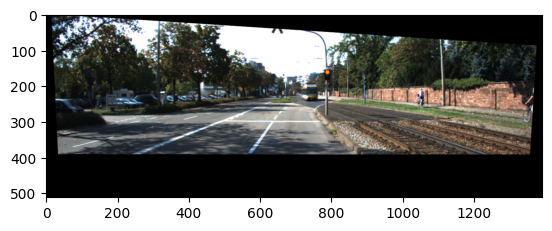

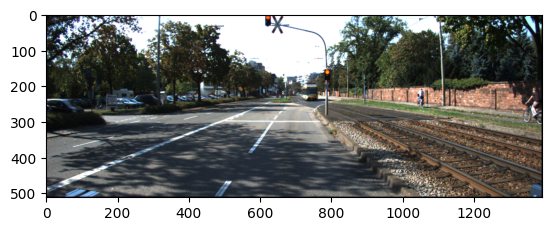

In [6]:
psnr_sum,ssim_sum,ind = (0,0,0)

for in_file,warp_file in zip(input_files,warped_files):

    # open file
    in_img = np.array(Image.open(in_file))
    warp_img = np.array(Image.open(warp_file))

    # grayscale
    warped_img_uint8 = (warp_img).astype(np.uint8)
    warp_gray = cv2.cvtColor(warped_img_uint8,cv2.COLOR_RGB2GRAY)
    in_img_uint8 = (in_img).astype(np.uint8)
    in_gray = cv2.cvtColor(in_img_uint8,cv2.COLOR_RGB2GRAY)

    # keypoints
    sift = cv2.SIFT_create()
    kp, descriptors = sift.detectAndCompute(warp_gray,None)
    true_kp, true_descriptors = sift.detectAndCompute(in_gray,None)

    # Matcher
    matcher = cv2.BFMatcher()
    matches = matcher.knnMatch(descriptors, true_descriptors, k=2)

    # RANSAC
    good_matches = []
    for m, n in matches:
        if m.distance < .85 * n.distance:
            good_matches.append(m)

    # reshape
    src_pts = np.float32([kp[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([true_kp[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # unwarp
    M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    unwarped_img = cv2.warpPerspective(warp_img, M, (warp_img.shape[1], warp_img.shape[0]))

    # display_imgs(unwarped_img,in_img)

    # results
    psnr_tmp,ssim_tmp = psnr_ssim_rect(np.uint8(in_img),np.uint8(unwarped_img))
    print("image " + str(ind) + ": ", psnr_tmp, ssim_tmp)
    ind += 1
    psnr_sum += psnr_tmp
    ssim_sum += ssim_tmp

print()
print("Average PSNR: ", psnr_sum / len(input_files))
print("Average SSIM: ", ssim_sum / len(input_files))
print()

display_imgs(unwarped_img,in_img)

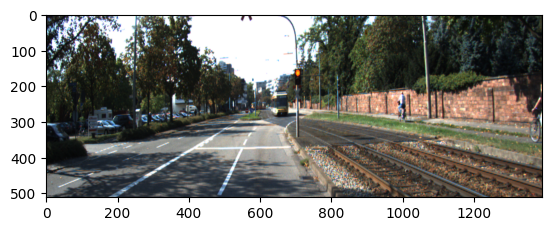

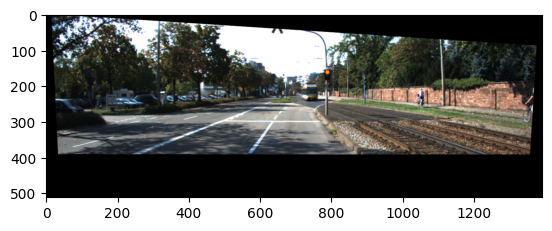

In [7]:
display_imgs(warp_img,unwarped_img)